In [1]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np


/media/wuguo-buaa/LENOVO_USB_HDD/PycharmProjects/Machine_learning_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import pandas as pd

filepath = "./iot23_combined_oversample.csv"
df = pd.read_csv(filepath)
del df['Unnamed: 0']

In [3]:
df.loc[(df.category == 'Malware'), 'category'] = 1
df.loc[(df.category == 'Benign'), 'category'] = 0
df['category'].value_counts()

1    2362709
0    2362709
Name: category, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'service_-', 'service_dhcp', 'service_dns', 'service_http', 'service_ssh', 'service_ssl', 'service_irc', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']].values
Y = df['category'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=10, test_size=0.2)
Y_train, Y_test = Y_train, Y_test

In [11]:
type(Y_train)

numpy.ndarray

In [5]:
basemodel1 = XGBClassifier(n_estimators=100,max_depth=10,learning_rate=0.05,min_child_weight=2)
basemodel2 = lgb.LGBMClassifier()
basemodel3 = RandomForestClassifier(random_state=1,n_estimators=200,min_samples_leaf=10)
lr = LogisticRegression(random_state=0)
sclf = StackingClassifier(classifiers=[basemodel1, basemodel2, basemodel3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('5-fold cross validation:\n')

for basemodel, label in zip([basemodel1, basemodel2, basemodel3, sclf],
                       ['xgboost',
                        'lightgbm',
                        'Random Forest',
                        'StackingClassifier']):
    # basemodel.fit(X_train,Y_train)
    scores = model_selection.cross_val_score(basemodel,X, Y.astype(int),
                                               cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
             % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.86 (+/- 0.09) [xgboost]
Accuracy: 0.86 (+/- 0.09) [lightgbm]
Accuracy: 0.86 (+/- 0.09) [Random Forest]
Accuracy: 0.86 (+/- 0.09) [StackingClassifier]


In [12]:
sclf.fit(X_train,Y_train.astype(int))

StackingClassifier(classifiers=[XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.05, max_bin=None,
                                              ma...
                                              max_leaves=None,
               

In [17]:
from sklearn.metrics import classification_report

print('prediction:')
y_pred = sclf.predict(X_test)
print(y_pred)
print()

print('Score:')
score = sclf.score(X_test,Y_test.astype(int))
print(score)
print("Classifiction Report :")
print(classification_report(Y_test.astype(int), y_pred))

prediction:
[1 0 0 ... 0 1 0]

Score:
0.8811703509952554
Classifiction Report :
              precision    recall  f1-score   support

           0       0.93      0.82      0.87    472533
           1       0.84      0.94      0.89    472551

    accuracy                           0.88    945084
   macro avg       0.89      0.88      0.88    945084
weighted avg       0.89      0.88      0.88    945084



/media/wuguo-buaa/LENOVO_USB_HDD/PycharmProjects/Machine_learning_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


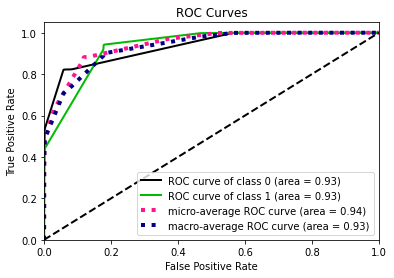

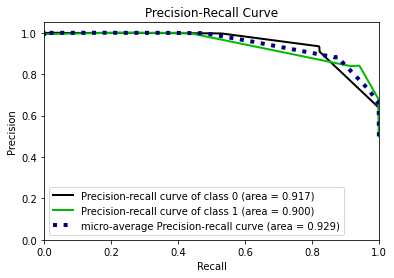

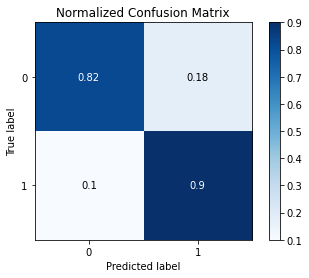

In [19]:
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict
import scikitplot as skplt
predicted_probas = sclf.predict_proba(X_test)
#ROC曲线
skplt.metrics.plot_roc(Y_test.astype(int), predicted_probas)
plt.savefig('./STACKING/PIC/model_classification_roc.jpg')
#P-R曲线
skplt.metrics.plot_precision_recall(Y_test.astype(int), predicted_probas, cmap='nipy_spectral')
plt.savefig('./STACKING/PIC/model_classification_pr.jpg')
#混淆矩阵
predictions = cross_val_predict(sclf, X, Y.astype(int))
plot = skplt.metrics.plot_confusion_matrix(Y.astype(int), predictions, normalize=True)
plt.savefig('./STACKING/PIC/model_classification_confusionMatrix.jpg')

In [20]:
import joblib
#lr是一个DT模型
joblib.dump(sclf, './STACKING/sclf.model')
# DT = joblib.load('dt.model')

['./STACKING/sclf.model']